In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plot

In [3]:
spark=SparkSession.builder.appName("Project1").getOrCreate()

In [4]:
pyspark_df=spark.read.csv('drive/MyDrive/Colab Notebooks/data/Project 1_dataset_bank-full.csv',header=True,inferSchema=True,sep =";",quote='')

In [5]:
pyspark_df=pyspark_df.toDF(*list(map(lambda x: x.replace('"', ''), pyspark_df.columns)))

In [6]:
for column_name,column_type in pyspark_df.dtypes:
  if column_type == 'string':
    pyspark_df = pyspark_df.withColumn(column_name, regexp_replace(column_name, '"', ''))
pyspark_df = pyspark_df.withColumn("age", pyspark_df.age.cast("integer"))

In [7]:
pyspark_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [8]:
#Success Rate
success_rate=pyspark_df.filter("y=='yes'").count()/pyspark_df.count()
print(f'{success_rate*100:.2f}')

11.70


In [9]:
#failure rate
failure_rate=(1-success_rate) # can also be done by: failure_rate=pyspark_df.filter("y!='yes'").count()/pyspark_df.count()
print(f'{failure_rate*100:.2f}')
#

88.30


In [10]:
#minimum, maximum and average
avg_age=pyspark_df.agg(max('age').alias('Max'),min('age').alias('Min'),avg('age').alias('Mean'))
avg_age.show()

+---+---+-----------------+
|Max|Min|             Mean|
+---+---+-----------------+
| 95| 18|40.93621021432837|
+---+---+-----------------+



In [11]:
##finding max value using rdd lambda operation
import builtins as p
age_rdd=pyspark_df.select('age').rdd
age_rdd.map(lambda x:(1,x[0])).groupByKey().map(lambda x: p.max(list(x[-1]))).collect()

[95]

In [12]:
#average and median balance
pyspark_df.agg(avg('balance').alias('Average Balance'),expr('percentile(balance, array(0.5))')[0].alias('Median')).show()

+------------------+------+
|   Average Balance|Median|
+------------------+------+
|1362.2720576850766| 448.0|
+------------------+------+



In [13]:
#finding number of account holder by age
age_df=pyspark_df.filter("y=='yes'").groupby('age').agg({'*':'count'}).orderBy('age', ascending=False)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Age')]

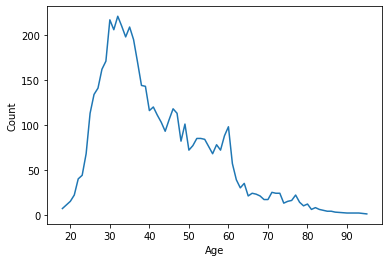

In [14]:
# from the below graph we can see that age group of 25-40 has highest number of account holders
sns.lineplot(x = "age", y = "count(1)", data = age_df.toPandas()).set(xlabel='Age', ylabel='Count')

In [15]:
#finding number of account holder by their marital status
marital_df=pyspark_df.filter("y=='yes'").groupby('marital').agg({'*':'count'}).orderBy('marital', ascending=False)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Marital')]

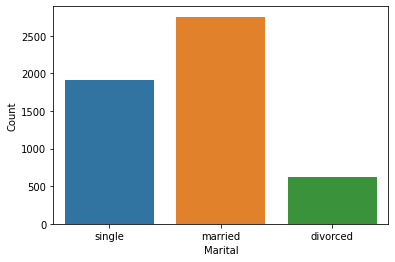

In [16]:
#from below graph we can see the maximum of account holders are married and very few of them are divorced
sns.barplot(x = "marital", y = "count(1)", data = marital_df.toPandas()).set(xlabel='Marital', ylabel='Count')

In [17]:
#finding number of account holder by their age and marital status
age_marital_df=pyspark_df.filter("y=='yes'").groupby('age','marital').agg({'*':'count'}).orderBy(['marital','age'], ascending=False)
# age_marital_df=pyspark_df.filter("y=='yes'").groupby('age','marital').agg({'*':'count'}).orderBy(pyspark_df.marital.desc(),pyspark_df.age.asc())

In [18]:
#adding new column for unique age and marital group
age_marital_df=age_marital_df.withColumn("age_marital",concat(col("age"), lit("_"), col("marital")))

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Marital Age')]

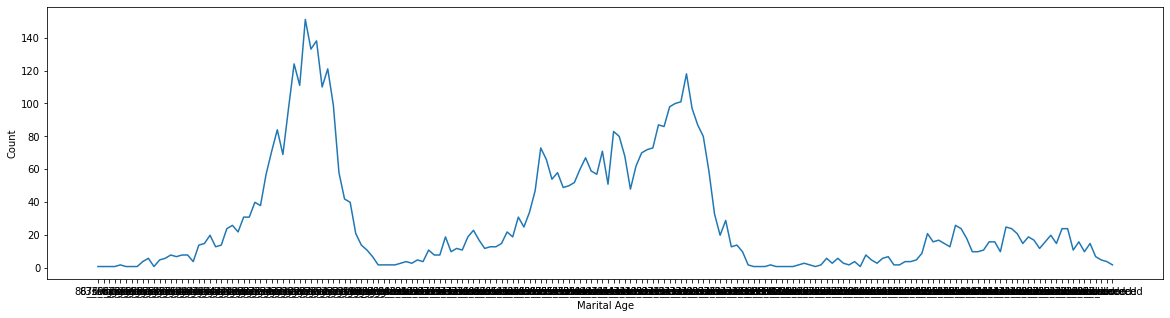

In [19]:
#from the below graph we can see that age have high effect on single marital status, low in married marital and very low in divorced marital status
fig, ax = plot.subplots(figsize=(20, 5))
sns.lineplot(x = "age_marital", y = "count(1)", data = age_marital_df.toPandas()).set(xlabel='Marital Age', ylabel='Count')

In [20]:
#udf to categorize based on the age
def return_age_type(age):
  if age<=20:
    return "teen"
  if age>20 and age<=35:
    return "adult"
  if age>40 and age<70:
    return "middle-aged"
  return "old"

age_udf=udf(lambda x:return_age_type(x))

In [21]:
#adding age category column in the given df
pyspark_df_f_engineering=pyspark_df.withColumn("age_type",age_udf(pyspark_df.age))

In [22]:
#finding number of account holder by age category
age_df_feature_engineering=pyspark_df_f_engineering.filter("y=='yes'").groupby('age_type').agg({'*':'count'}).orderBy('age_type', ascending=False)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Age Category')]

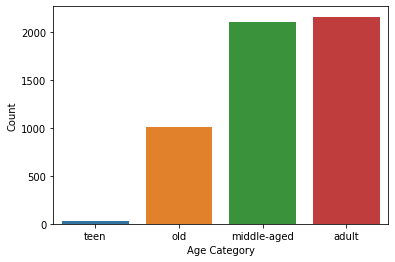

In [23]:
#from below graph we can see the maximum of account holders are adult or middle aged
sns.barplot(x = "age_type", y = "count(1)", data = age_df_feature_engineering.toPandas()).set(xlabel='Age Category', ylabel='Count')